In [1]:
import torch
import numpy as np
import pandas as pd
import kagglehub
import os
import cv2
import random

from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm


In [2]:
!pip -q install kagglehub[pandas-datasets]
print("📥 Téléchargement du dataset...")
dataset_path = kagglehub.dataset_download("shafiullahshafin/c-nmc-2019-dataset")

print(f"✅ Dataset téléchargé ici : {dataset_path}")

def build_dataframe(base_path):
    data = []
    image_paths = glob(os.path.join(base_path, '**', '*.bmp'), recursive=True)

    print(f"🔍 Images trouvées : {len(image_paths)}")

    for img_path in image_paths:
        folder_name = os.path.basename(os.path.dirname(img_path))

        if 'all' in folder_name.lower():
            label = 'ALL'
        elif 'hem' in folder_name.lower():
            label = 'HEM' # Normal
        else:
            continue

        data.append({
            'image_path': img_path,
            'label': label,
            'filename': os.path.basename(img_path)
        })

    return pd.DataFrame(data)

df = build_dataframe(dataset_path)

print(f"\n📊 DataFrame construit avec {len(df)} images.")
print(df.head())

📥 Téléchargement du dataset...
Using Colab cache for faster access to the 'c-nmc-2019-dataset' dataset.
✅ Dataset téléchargé ici : /kaggle/input/c-nmc-2019-dataset
🔍 Images trouvées : 15114

📊 DataFrame construit avec 10661 images.
                                          image_path label  \
0  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
1  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
2  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
3  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
4  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   

              filename  
0   UID_28_5_3_all.bmp  
1  UID_45_24_5_all.bmp  
2   UID_45_7_1_all.bmp  
3  UID_52_10_5_all.bmp  
4  UID_52_21_7_all.bmp  


## Baseline ResNet



### Dataset

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
  seed: int = 42
  batch_size: int = 32
  lr : float = 1e-4
  epoch: int = 10
  train_split: float = 0.8
  dropout: float = 0.5
  weight_decay: float = 1e-3

  @property
  def test_split(self):
    return round((1 - self.train_split) / 2, 2)

  @property
  def validation_split(self):
    return self.test_split

  @property
  def device(self):
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


config = Config()
config.device

device(type='cuda')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.seed)

In [5]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class LeukomiaDataset(Dataset):
    def __init__(self, df, transform=None):
      super().__init__()
      self.label_map = {"HEM": 0, "ALL": 1}

      self.X = df['image_path'].values
      self.y = df['label'].map(self.label_map).values
      self.transform = transform

      if transform is None:
        self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomRotation(15),
          transforms.ToTensor(),
          transforms.ColorJitter(
              brightness=0.2,
              contrast=0.2,
              saturation=0.1,
          ),
          transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      img = Image.open(self.X[idx]).convert('RGB')
      label = torch.tensor(self.y[idx], dtype=torch.long)

      if self.transform:
        img = self.transform(img)

      return img, label


leukomia_dataset = LeukomiaDataset(df)
sample_X, sample_y = next(iter(leukomia_dataset))
sample_X.shape, sample_y

(torch.Size([3, 224, 224]), tensor(1))

In [6]:
len_train_data = int(len(df) * config.train_split)
len_validation_data = int(len(df) * config.validation_split)
len_test_data = int(len(df) * config.test_split)

df_shuffled = df.sample(frac=1, random_state=config.seed).reset_index(drop=True)
df_train = df_shuffled[:len_train_data][:]
df_validation = df_shuffled[len_train_data:len_train_data+len_validation_data][:]
df_test = df_shuffled[len_train_data+len_validation_data:][:]

df_train.shape, df_validation.shape, df_test.shape

((8528, 3), (1066, 3), (1067, 3))

In [7]:
### Test and validation transform to reproductibily
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = LeukomiaDataset(df_train, transform=None)
validation_dataset = LeukomiaDataset(df_validation, transform=test_transform)
test_dataset = LeukomiaDataset(df_test, transform=test_transform)


def get_dataloader(dataset, shuffle=False):
  generator = torch.Generator()
  generator.manual_seed(config.seed)

  return DataLoader(dataset,
                    batch_size=config.batch_size,
                    shuffle=shuffle,
                    num_workers=2,
                    pin_memory=True,
                    drop_last=shuffle,
                    persistent_workers=True,
                    prefetch_factor=2,
                    generator=generator if shuffle else None
        )

def get_dataloaders(train_dataset, validation_dataset, test_dataset):
  train_dataloader = get_dataloader(train_dataset, shuffle=True)
  validation_dataloader = get_dataloader(validation_dataset)
  test_dataloader = get_dataloader(test_dataset)

  return train_dataloader, validation_dataloader, test_dataloader


train_dataloader, validation_dataloader, test_dataloader = get_dataloaders(
    train_dataset, validation_dataset, test_dataset
)
img_tensor, y_tensor = next(iter(train_dataloader))
img_tensor.shape, y_tensor.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Training model


In [8]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [9]:
from typing import NamedTuple, List, Dict, Any

class TrainingResult(NamedTuple):
    """Résultats de l'entraînement du modèle."""
    model_state_dict: Dict[str, Any]
    optimizer_state_dict: Dict[str, Any]
    scheduler_state_dict: Dict[str, Any]
    train_losses: List[float]
    validation_losses: List[float]
    best_val_loss: float

 #### Reset18

In [10]:
import logging
import sys

def setup_colab_logger(logger_name="LeukemiaLog"):
    logger = logging.getLogger(logger_name)
    if logger.hasHandlers():
        logger.handlers.clear()

    logger.setLevel(logging.INFO)
    logger.propagate = False
    formatter = logging.Formatter('%(asctime)s - %(message)s', datefmt='%H:%M:%S')

    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    return logger

logger = setup_colab_logger()

In [15]:
import copy

def train_model(model,
                config,
                optimizer,
                train_dataloader,
                validation_dataloader,
                scheduler=None):
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    best_model_weights = None
    best_optimizer_state = None
    best_scheduler_state = None

    for epoch in tqdm(range(config.epoch), desc="Global Progress"):
        model.train()
        epoch_train_loss = 0

        for image_tensor, label in train_dataloader:
            img_tensor = image_tensor.to(config.device)
            label = label.to(config.device)
            optimizer.zero_grad()
            output = model(img_tensor)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_dataloader))

        model.eval()
        epoch_val_loss = 0
        for image_tensor, label in validation_dataloader:
            img_tensor = image_tensor.to(config.device)
            label = label.to(config.device)
            with torch.no_grad():
                output = model(img_tensor)
                loss = criterion(output, label)
                epoch_val_loss += loss.item()

        validation_losses.append(epoch_val_loss / len(validation_dataloader))
        if scheduler is not None:
            scheduler.step(validation_losses[-1])


        if validation_losses[-1] < best_val_loss:
            best_val_loss = validation_losses[-1]
            best_model_weights = copy.deepcopy(model.state_dict())
            best_optimizer_state = copy.deepcopy(optimizer.state_dict())
            best_scheduler_state = copy.deepcopy(scheduler.state_dict()) if scheduler else None
            logger.info(f"Best model found at epoch {epoch}")

        logger.info(f"Epoch {epoch+1}/{config.epoch} - "
                   f"Train Loss: {train_losses[-1]:.4f} - "
                   f"Val Loss: {validation_losses[-1]:.4f} - "
                   f"LR : {optimizer.param_groups[0]['lr']:.6f}")


    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return TrainingResult(
        model_state_dict=best_model_weights,
        optimizer_state_dict=best_optimizer_state,
        scheduler_state_dict=best_scheduler_state,
        train_losses=train_losses,
        validation_losses=validation_losses,
        best_val_loss=best_val_loss
    )

In [16]:
from torchvision.models import ResNet18_Weights

config = Config(lr=1e-4, epoch=50, dropout=0.3, weight_decay=1e-3)

model = torch.hub.load('pytorch/vision:v0.10.0',
                       'resnet18',
                       weights=ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(config.dropout),
    torch.nn.Linear(model.fc.in_features, 2)
)

model = model.to(config.device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config.lr,
                              weight_decay=config.weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

train_dataloader, validation_dataloader, test_dataloader = get_dataloaders(
    train_dataset, validation_dataset, test_dataset
)

result_train = train_model(model,
    config=config,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    scheduler=scheduler
)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Global Progress:   0%|          | 0/50 [00:00<?, ?it/s]

20:28:15 - Best model found at epoch 0
20:28:15 - Epoch 1/50 - Train Loss: 0.3791 - Val Loss: 0.2658 - LR : 0.000100
20:28:54 - Epoch 2/50 - Train Loss: 0.2683 - Val Loss: 0.2949 - LR : 0.000100
20:29:33 - Epoch 3/50 - Train Loss: 0.2423 - Val Loss: 0.3014 - LR : 0.000100
20:30:12 - Best model found at epoch 3
20:30:12 - Epoch 4/50 - Train Loss: 0.2076 - Val Loss: 0.2068 - LR : 0.000100
20:30:51 - Epoch 5/50 - Train Loss: 0.1876 - Val Loss: 0.2072 - LR : 0.000100
20:31:30 - Best model found at epoch 5
20:31:30 - Epoch 6/50 - Train Loss: 0.1671 - Val Loss: 0.1428 - LR : 0.000100
20:32:10 - Epoch 7/50 - Train Loss: 0.1490 - Val Loss: 0.1452 - LR : 0.000100
20:32:49 - Best model found at epoch 7
20:32:49 - Epoch 8/50 - Train Loss: 0.1472 - Val Loss: 0.1357 - LR : 0.000100
20:33:29 - Best model found at epoch 8
20:33:29 - Epoch 9/50 - Train Loss: 0.1303 - Val Loss: 0.1274 - LR : 0.000100
20:34:09 - Epoch 10/50 - Train Loss: 0.1312 - Val Loss: 0.1794 - LR : 0.000100
20:34:48 - Epoch 11/50 -

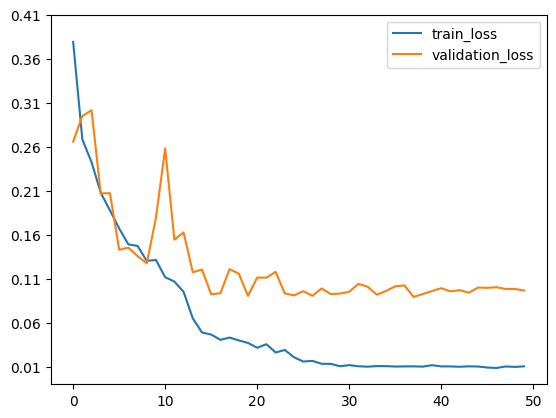

In [17]:
train_losses = result_train.train_losses
validation_losses = result_train.validation_losses

plt.plot(np.arange(config.epoch), train_losses, label='train_loss')
plt.plot(np.arange(config.epoch), validation_losses, label='validation_loss')
plt.legend()
plt.yticks(np.arange(0.01, max(train_losses + validation_losses) + 0.05, 0.05))
plt.show()

In [18]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 59.2 MB/s eta 0:00:00


In [19]:
import seaborn as sns
from torchmetrics.classification import BinaryAccuracy, BinaryRecall, BinaryPrecision, BinaryF1Score, BinaryConfusionMatrix

def test_model(model, dataloader, device):
    model.eval()

    # 1. Initialisation des métriques (envoyées sur le GPU/CPU)
    acc_metric = BinaryAccuracy().to(device)
    rec_metric = BinaryRecall().to(device)
    prec_metric = BinaryPrecision().to(device)
    f1_metric = BinaryF1Score().to(device)
    confmat_metric = BinaryConfusionMatrix().to(device)

    with torch.no_grad():
        for image_tensor, label in dataloader:
            img_tensor = image_tensor.to(device)
            label = label.to(device)

            logits = model(img_tensor) # Forme: [Batch, 2]
            probs = torch.softmax(logits, dim=1)[:, 1]

            acc_metric.update(probs, label)
            rec_metric.update(probs, label)
            prec_metric.update(probs, label)
            f1_metric.update(probs, label)
            confmat_metric.update(probs, label)

    final_acc = acc_metric.compute()
    final_rec = rec_metric.compute()
    final_prec = prec_metric.compute()
    final_f1 = f1_metric.compute()
    conf_matrix = confmat_metric.compute()

    print("-" * 30)
    print(f"Accuracy : {final_acc:.4f}")
    print(f"Recall   : {final_rec:.4f} (Sensibilité)")
    print(f"Precision: {final_prec:.4f}")
    print(f"F1 Score : {final_f1:.4f}")
    print("-" * 30)

    acc_metric.reset()
    rec_metric.reset()
    prec_metric.reset()
    f1_metric.reset()
    confmat_metric.reset()

    return conf_matrix

def plot_confusion_matrix(conf_matrix, model_name):
    cm_np = conf_matrix.cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_np, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Sain', 'Malade'],
                yticklabels=['Sain', 'Malade'])
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion - Leucémie - {model_name}')
    plt.show()


------------------------------
Accuracy : 0.9766
Recall   : 0.9832 (Sensibilité)
Precision: 0.9818
F1 Score : 0.9825
------------------------------


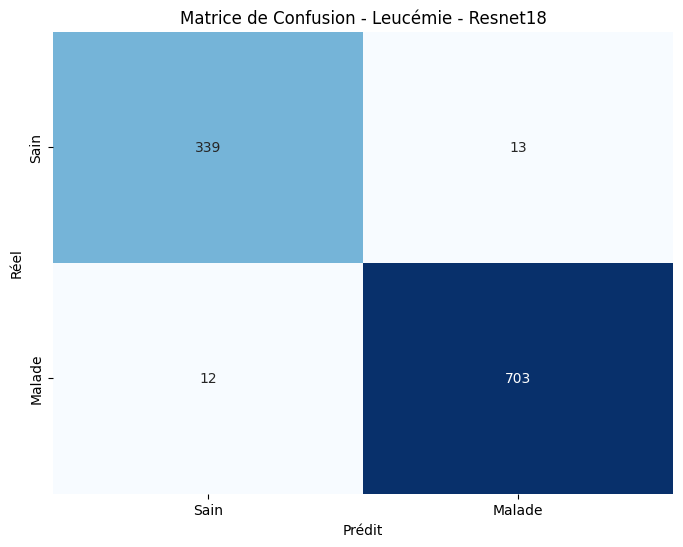

In [21]:
model_resnet18 = model
conf_matrix = test_model(model_resnet18, test_dataloader, config.device)

plot_confusion_matrix(conf_matrix, 'Resnet18')

In [29]:
dict_result = {
    "train_losses": train_losses,
    "validation_losses": validation_losses,
    "best_val_loss": result_train.best_val_loss,
    "model_state_dict": result_train.model_state_dict,
    "optimizer_state_dict": result_train.optimizer_state_dict,
    "scheduler_state_dict": result_train.scheduler_state_dict
}
torch.save(dict_result, '/content/resnet18_training_result.pth')

In [31]:
checkpoints = torch.load("/content/resnet18_training_result.pth", weights_only=False)
list(checkpoints.keys())

['train_losses',
 'validation_losses',
 'best_val_loss',
 'model_state_dict',
 'optimizer_state_dict',
 'scheduler_state_dict']